In [1]:
import torch 
import torch.nn as nn

from torchvision import transforms, datasets
from torchsummary import summary


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

torch.__version__

/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.13.1'

In [2]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = 'mps'

## CIFAR10: Image Classification of 10 classes

### Getting datasets

In [3]:
image_folder = './images/'

In [4]:
train_ds = datasets.CIFAR10(root=image_folder, 
                            download=True,
                            transform=transforms.ToTensor(),
                            train=True,
                            )

test_ds = datasets.CIFAR10(root=image_folder,
                            download=True,
                            transform=transforms.ToTensor(),
                            train=False,
                            )


Files already downloaded and verified
Files already downloaded and verified


In [5]:
classes = train_ds.classes

In [6]:
print(f"Shape of train set: {len(train_ds)}")
print(f"Shape of test set: {len(test_ds)}")

Shape of train set: 50000
Shape of test set: 10000


### Subset Training data to from train & valid sets

In [7]:
# Checking for class balance
pd.Series(train_ds.targets).value_counts()
# Balanced Dataset

6    5000
9    5000
4    5000
1    5000
2    5000
7    5000
8    5000
3    5000
5    5000
0    5000
dtype: int64

In [8]:
# Subset from train data 
valid_ds = torch.utils.data.Subset(train_ds, indices=torch.arange(10000))
train_ds = torch.utils.data.Subset(train_ds, indices=torch.arange(10000, len(train_ds)))

In [9]:
print(f"Shape of train set: {len(train_ds)}")
print(f"Shape of valid set: {len(valid_ds)}")
print(f"Shape of test set: {len(test_ds)}")

Shape of train set: 40000
Shape of valid set: 10000
Shape of test set: 10000


### Adding Data Augmentation to train_ds

In [10]:
train_ds.dataset.transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomGrayscale(),
    transforms.ToTensor()
])

### Examples of Images 

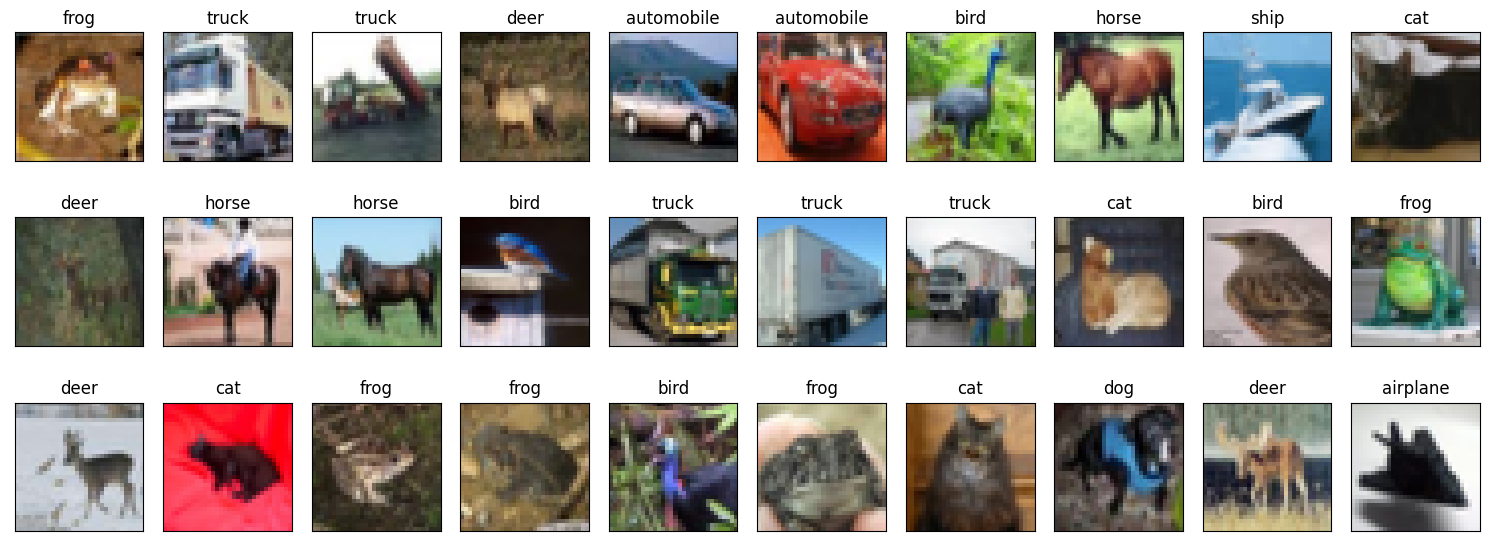

In [11]:
fig = plt.figure(figsize=(15, 6), )

for i in range(30):
    ax = fig.add_subplot(3, 10, i+1)
    ax.set_title(f"{classes[train_ds.dataset.targets[i]]}")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(train_ds.dataset.data[i])
    
fig.set_tight_layout(True)

### Adding DataLoader Wrapper

In [12]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=64, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True)

### Showing Augmented Images

In [13]:
(batch_images, batch_labels) = next(iter(train_dl))    

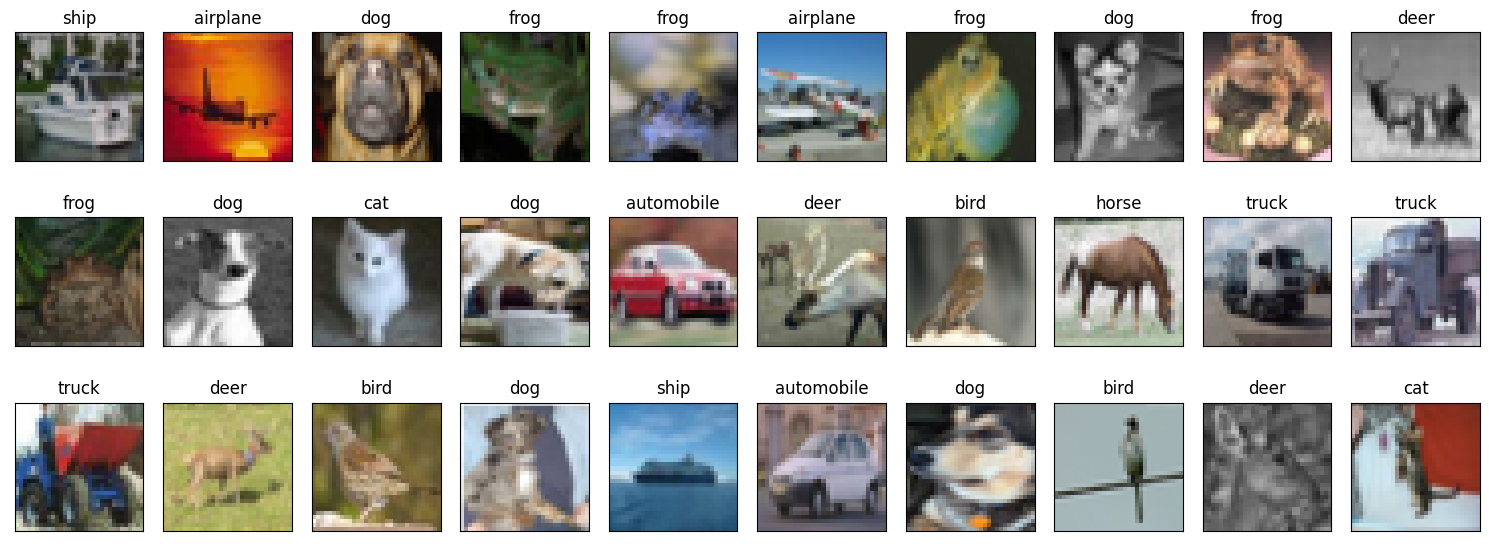

In [14]:
fig = plt.figure(figsize=(15, 6))

for i in range(30):
    ax = fig.add_subplot(3, 10, i+1)
    ax.set_title(f"{classes[batch_labels[i]]}")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(batch_images[i].permute(1, 2, 0))

fig.set_tight_layout(True)

### Building Model

In [37]:
class CNNClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=8*8*64, out_features=1024)
        self.relu1 = nn.ReLU()

        self.dropout = nn.Dropout()
        
        self.fc2 = nn.Linear(in_features=1024, out_features=len(classes))

    def forward(self, x):
        x = self.feature_extractor(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)

        logits = self.fc2(x)

        return logits

In [38]:
model = CNNClassifier().to(device)
summary(model, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 8, 8]            --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          1,792
|    └─ReLU: 2-2                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 64, 32, 32]          36,928
|    └─ReLU: 2-4                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-5                    [-1, 64, 16, 16]          --
|    └─Conv2d: 2-6                       [-1, 64, 16, 16]          36,928
|    └─ReLU: 2-7                         [-1, 64, 16, 16]          --
|    └─MaxPool2d: 2-8                    [-1, 64, 8, 8]            --
├─Flatten: 1-2                           [-1, 4096]                --
├─Linear: 1-3                            [-1, 1024]                4,195,328
├─ReLU: 1-4                              [-1, 1024]                --
├─Linear: 1-5                            [-1, 10]                  

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 8, 8]            --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          1,792
|    └─ReLU: 2-2                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 64, 32, 32]          36,928
|    └─ReLU: 2-4                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-5                    [-1, 64, 16, 16]          --
|    └─Conv2d: 2-6                       [-1, 64, 16, 16]          36,928
|    └─ReLU: 2-7                         [-1, 64, 16, 16]          --
|    └─MaxPool2d: 2-8                    [-1, 64, 8, 8]            --
├─Flatten: 1-2                           [-1, 4096]                --
├─Linear: 1-3                            [-1, 1024]                4,195,328
├─ReLU: 1-4                              [-1, 1024]                --
├─Linear: 1-5                            [-1, 10]                  

In [39]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() ,lr=0.001)

In [40]:
def train(data_loader, model, loss_fn, optimizer):

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred.to(device), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [41]:
def valid(data_loader, model, loss_fn, optimizer):
    
    valid_loss, valid_acc = 0, 0
    
    with torch.no_grad():
        for X, y in data_loader:

            X, y = X.to(device), y.to(device)

            pred = model(X)
            loss = loss_fn(pred, y)

            valid_loss += loss.item().float()
            valid_acc += (pred.argmax(dim=1) == y).float().sum().item()

        valid_acc /= len(data_loader.dataset)
        valid_loss /= len(data_loader.dataset)
    
    print(f"Test Error: \n Accuracy: {(100*valid_acc):>0.1f}%, Avg loss: {valid_loss:>8f} \n")

In [42]:
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    model.train()
    train(train_dl, model, loss_fn, optimizer)
    model.eval()
    valid(valid_dl, model)
print("Done!")

Epoch 1
-------------------------------


RuntimeError: Input type (MPSFloatType) and weight type (torch.FloatTensor) should be the same